In [ ]:
#| echo: false

# This cell will not be rendered but is to hide warnings and limit the rows shown

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('statsforecast').setLevel(logging.ERROR)

import pandas as pd
pd.set_option('display.max_rows', 6)

# Holt Winters Model

> Step-by-step guide on using the `Holt Winters Model` with `Statsforecast`.

During this walkthrough, we will become familiar with the main `StatsForecast` class and some relevant methods such as `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation` in other.

The text in this article is largely taken from:
1. [Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python.](https://link.springer.com/book/10.1007/978-3-031-13584-2) 
2. Ivan Svetunkov. [Forecasting and Analytics with the Augmented Dynamic Adaptive Model (ADAM)](https://openforecast.org/adam/)
3. [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)
4. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting Principles and Practice (3rd ed)”](https://otexts.com/fpp3/tscv.html).

## Table of Contents

* [Introduction](#introduction)
* [Holt-Winters Model](#model)
* [Loading libraries and data](#loading)
* [Explore data with the plot method](#plotting)
* [Split the data into training and testing](#splitting)
* [Implementation of Holt-Winters with StatsForecast](#implementation)
* [Cross-validation](#cross_validate)
* [Model evaluation](#evaluate)
* [References](#references)

## Introduction<a class="anchor" id="introduction"></a>

The Holt-Winter model, also known as the triple exponential smoothing method, is a forecasting technique widely used in time series analysis. It was developed by Charles Holt and Peter Winters in 1960 as an improvement on Holt's double exponential smoothing method.

The Holt-Winter model is used to predict future values of a time series that exhibits a trend and seasonality. The model uses three smoothing parameters, one for estimating the trend, another for estimating the level or base level of the time series, and another for estimating seasonality. These parameters are called α, β and γ, respectively.

The Holt-Winter model is an extension of Holt's double exponential smoothing method, which uses only two smoothing parameters to estimate the trend and base level of the time series. The Holt-Winter model improves the accuracy of the forecasts by adding a third smoothing parameter for seasonality.

One of the main advantages of the Holt-Winter model is that it is easy to implement and does not require a large amount of historical data to generate accurate predictions. Furthermore, the model is highly adaptable and can be customized to fit a wide variety of time series with seasonality.

However, the Holt-Winter model has some limitations. For example, the model assumes that the time series is stationary and that seasonality is constant. If the time series is not stationary or has non-constant seasonality, the Holt-Winter model may not be the most appropriate.

In general, the Holt-Winter model is a useful and widely used technique in time series analysis, especially when the series is expected to exhibit a constant trend and seasonality.

## Holt-Winters Method <a class="anchor" id="model"></a>

The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations — one for the level $\ell_{t}$, one for the trend $b_t$, and one for the seasonal component $s_t$ , with corresponding smoothing parameters $\alpha$ , $\beta^*$ and $\gamma$. We use  $m$ to denote the period of the seasonality, i.e., the number of seasons in a year. For example, for quarterly data  $m=4$, and for monthly data  $m=12$.

There are two variations to this method that differ in the nature of the seasonal component. The additive method is preferred when the seasonal variations are roughly constant through the series, while the multiplicative method is preferred when the seasonal variations are changing proportional to the level of the series. With the additive method, the seasonal component is expressed in absolute terms in the scale of the observed series, and in the level equation the series is seasonally adjusted by subtracting the seasonal component. Within each year, the seasonal component will add up to approximately zero. With the multiplicative method, the seasonal component is expressed in relative terms (percentages), and the series is seasonally adjusted by dividing through by the seasonal component. Within each year, the seasonal component will sum up to approximately $m$.

### Holt-Winters’ additive method
Holt-Winters' additive method is a time series forecasting technique that extends the Holt-Winters' method by incorporating an additive seasonality component. It is suitable for time series data that exhibit a seasonal pattern that changes over time.

The Holt-Winters' additive method uses three smoothing parameters - alpha (α), beta (β), and gamma (γ) - to estimate the level, trend, and seasonal components of the time series. The alpha parameter controls the smoothing of the level component, the beta parameter controls the smoothing of the trend component, and the gamma parameter controls the smoothing of the additive seasonal component.

The forecasting process involves three steps: first, the level, trend, and seasonal components are estimated using the smoothing parameters and the historical data; second, these components are used to forecast future values of the time series; and third, the forecasted values are adjusted for the seasonal component using an additive factor.

One of the advantages of Holt-Winters' additive method is that it can handle time series data with an additive seasonality component, which is common in many real-world applications. The method is also easy to implement and can be extended to handle time series data with changing seasonal patterns.

However, the method has some limitations. It assumes that the seasonality pattern is additive, which may not be the case for all time series. Additionally, the method requires a sufficient amount of historical data to accurately estimate the smoothing parameters and the seasonal component.

Overall, Holt-Winters' additive method is a powerful and widely used forecasting technique that can be used to generate accurate predictions for time series data with an additive seasonality component. The method is easy to implement and can be extended to handle time series data with changing seasonal patterns.

The component form for the additive method is:

\begin{align*}
  \hat{y}_{t+h|t} &= \ell_{t} + hb_{t} + s_{t+h-m(k+1)} \\
  \ell_{t} &= \alpha(y_{t} - s_{t-m}) + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  b_{t} &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1}\\
  s_{t} &= \gamma (y_{t}-\ell_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m},
\end{align*}

where $k$ is the integer part of $(h-1)/m$, which ensures that the estimates of the seasonal indices used for forecasting come from the final year of the sample. The level equation shows a weighted average between the seasonally adjusted observation $(y_{t} - s_{t-m})$ and the non-seasonal forecast $(\ell_{t-1}+b_{t-1})$ for time $t$. The trend equation is identical to Holt’s linear method. The seasonal equation shows a weighted average between the current seasonal index, $(y_{t}-\ell_{t-1}-b_{t-1})$, and the seasonal index of the same season last year (i.e., $m$ time periods ago).

The equation for the seasonal component is often expressed as

$$s_{t} = \gamma^* (y_{t}-\ell_{t})+ (1-\gamma^*)s_{t-m}.$$

If we substitute $\ell_{t}$ from the smoothing equation for the level of the component form above, we get

$$s_{t} = \gamma^*(1-\alpha) (y_{t}-\ell_{t-1}-b_{t-1})+ [1-\gamma^*(1-\alpha)]s_{t-m},$$

which is identical to the smoothing equation for the seasonal component we specify here, with $\gamma=\gamma^*(1-\alpha)$. The usual parameter restriction is $0\le\gamma^*\le1$, which translates to $0\le\gamma\le 1-\alpha$.


### Holt-Winters’ multiplicative method

The Holt-Winters' multiplicative method uses three smoothing parameters - alpha (α), beta (β), and gamma (γ) - to estimate the level, trend, and seasonal components of the time series. The alpha parameter controls the smoothing of the level component, the beta parameter controls the smoothing of the trend component, and the gamma parameter controls the smoothing of the multiplicative seasonal component.

The forecasting process involves three steps: first, the level, trend, and seasonal components are estimated using the smoothing parameters and the historical data; second, these components are used to forecast future values of the time series; and third, the forecasted values are adjusted for the seasonal component using a multiplicative factor.

One of the advantages of Holt-Winters' multiplicative method is that it can handle time series data with a multiplicative seasonality component, which is common in many real-world applications. The method is also easy to implement and can be extended to handle time series data with changing seasonal patterns.

However, the method has some limitations. It assumes that the seasonality pattern is multiplicative, which may not be the case for all time series. Additionally, the method requires a sufficient amount of historical data to accurately estimate the smoothing parameters and the seasonal component.

Overall, Holt-Winters' multiplicative method is a powerful and widely used forecasting technique that can be used to generate accurate predictions for time series data with a multiplicative seasonality component. The method is easy to implement and can be extended to handle time series data with changing seasonal patterns.

In the multiplicative version, the seasonality averages to one. Use the multiplicative method if the seasonal variation increases with the level.

\begin{align*}
  \hat{y}_{t+h|t} &= (\ell_{t} + hb_{t})s_{t+h-m(k+1)} \\
  \ell_{t} &= \alpha \frac{y_{t}}{s_{t-m}} + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  b_{t} &= \beta^*(\ell_{t}-\ell_{t-1}) + (1 - \beta^*)b_{t-1}                \\
  s_{t} &= \gamma \frac{y_{t}}{(\ell_{t-1} + b_{t-1})} + (1 - \gamma)s_{t-m}.
\end{align*}

### Mathematical models in the ETS taxonomy

I hope that it becomes more apparent to the reader how the ETS framework is built upon the idea of time series decomposition. By introducing different components, defining their types, and adding the equations for their update, we can construct models that would work better in capturing the key features of the time series. But we should also consider the potential change in components over time. The “transition” or “state” equations are supposed to reflect this change: they explain how the level, trend or seasonal components evolve.

As discussed in Section 2.2, given different types of components and their interactions, we end up with 30 models in the taxonomy. Tables 1 and 2 summarise mathematically all 30 ETS models shown graphically on Figures 1 and 2, presenting formulae for measurement and transition equations.


Table 1: Additive error ETS models

|    | Nonseasonal |Additive	|Multiplicative|
|----|-----------  |----------- |--------------|
|No trend|$\begin{aligned} &y_{t} = l_{t-1} + \epsilon_t \\  &l_t = l_{t-1} + \alpha \epsilon_t  \end{aligned}$ |$\begin{aligned} &y_{t} = l_{t-1} + s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} + \alpha \epsilon_t \\  &s_t = s_{t-m} + \gamma \epsilon_t  \end{aligned}$ |$\begin{aligned} &y_{t} = l_{t-1} s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} + \alpha \frac{\epsilon_t}{s_{t-m}} \\  &s_t = s_{t-m} + \gamma \frac{\epsilon_t}{l_{t-1}}  \end{aligned}$|
|Additive| $\begin{aligned} &y_{t} = l_{t-1} + b_{t-1} + \epsilon_t \\  &l_t = l_{t-1} + b_{t-1} + \alpha \epsilon_t \\  &b_t = b_{t-1} + \beta \epsilon_t  \end{aligned}$ | $\begin{aligned}  &y_{t} = l_{t-1} + b_{t-1} + s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} + b_{t-1} + \alpha \epsilon_t \\  &b_t = b_{t-1} + \beta \epsilon_t \\  &s_t = s_{t-m} + \gamma \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = (l_{t-1} + b_{t-1}) s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} + b_{t-1} + \alpha \frac{\epsilon_t}{s_{t-m}} \\  &b_t = b_{t-1} + \beta \frac{\epsilon_t}{s_{t-m}} \\  &s_t = s_{t-m} + \gamma \frac{\epsilon_t}{l_{t-1} + b_{t-1}}  \end{aligned}$|
|Additive damped| $\begin{aligned} &y_{t} = l_{t-1} + \phi b_{t-1} + \epsilon_t \\  &l_t = l_{t-1} + \phi b_{t-1} + \alpha \epsilon_t \\  &b_t = \phi b_{t-1} + \beta \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = l_{t-1} + \phi b_{t-1} + s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} + \phi b_{t-1} + \alpha \epsilon_t \\  &b_t = \phi b_{t-1} + \beta \epsilon_t \\  &s_t = s_{t-m} + \gamma \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = (l_{t-1} + \phi b_{t-1}) s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} + \phi b_{t-1} + \alpha \frac{\epsilon_t}{s_{t-m}} \\  &b_t = \phi b_{t-1} + \beta \frac{\epsilon_t}{s_{t-m}} \\  &s_t = s_{t-m} + \gamma \frac{\epsilon_t}{l_{t-1} + \phi b_{t-1}}  \end{aligned}$| 
|Multiplicative| $\begin{aligned} &y_{t} = l_{t-1} b_{t-1} + \epsilon_t \\  &l_t = l_{t-1} b_{t-1} + \alpha \epsilon_t \\  &b_t = b_{t-1} + \beta \frac{\epsilon_t}{l_{t-1}}  \end{aligned}$ | $\begin{aligned} &y_{t} = l_{t-1} b_{t-1} + s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} b_{t-1} + \alpha \epsilon_t \\  &b_t = b_{t-1} + \beta \frac{\epsilon_t}{l_{t-1}} \\  &s_t = s_{t-m} + \gamma \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = l_{t-1} b_{t-1} s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} b_{t-1} + \alpha \frac{\epsilon_t}{s_{t-m}} \\  &b_t = b_{t-1} + \beta \frac{\epsilon_t}{l_{t-1}s_{t-m}} \\  &s_t = s_{t-m} + \gamma \frac{\epsilon_t}{l_{t-1} b_{t-1}}  \end{aligned}$|
|Multiplicative damped| $\begin{aligned} &y_{t} = l_{t-1} b_{t-1}^\phi + \epsilon_t \\  &l_t = l_{t-1} b_{t-1}^\phi + \alpha \epsilon_t \\  &b_t = b_{t-1}^\phi + \beta \frac{\epsilon_t}{l_{t-1}}  \end{aligned}$ | $\begin{aligned} &y_{t} = l_{t-1} b_{t-1}^\phi + s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} b_{t-1}^\phi + \alpha \epsilon_t \\  &b_t = b_{t-1}^\phi + \beta \frac{\epsilon_t}{l_{t-1}} \\  &s_t = s_{t-m} + \gamma \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = l_{t-1} b_{t-1}^\phi s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} b_{t-1}^\phi + \alpha \frac{\epsilon_t}{s_{t-m}} \\  &b_t = b_{t-1}^\phi + \beta \frac{\epsilon_t}{l_{t-1}s_{t-m}} \\  &s_t = s_{t-m} + \gamma \frac{\epsilon_t}{l_{t-1} b_{t-1}}  \end{aligned}$|


Table 2: Multiplicative error ETS models

|      |Nonseasonal	 |Additive	|Multiplicative|
|------|-------------|----------|--------------|
|No trend| $\begin{aligned} &y_{t} = l_{t-1}(1 + \epsilon_t) \\  &l_t = l_{t-1}(1 + \alpha \epsilon_t)  \end{aligned}$ | $\begin{aligned} &y_{t} = (l_{t-1} + s_{t-m})(1 + \epsilon_t) \\  &l_t = l_{t-1} + \alpha \mu_{y,t} \epsilon_t \\  &s_t = s_{t-m} + \gamma \mu_{y,t} \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = l_{t-1} s_{t-m}(1 + \epsilon_t) \\  &l_t = l_{t-1}(1 + \alpha \epsilon_t) \\  &s_t = s_{t-m}(1 + \gamma \epsilon_t)  \end{aligned}$|
|Additive| $\begin{aligned} &y_{t} = (l_{t-1} + b_{t-1})(1 + \epsilon_t) \\  &l_t = (l_{t-1} + b_{t-1})(1 + \alpha \epsilon_t) \\  &b_t = b_{t-1} + \beta \mu_{y,t} \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = (l_{t-1} + b_{t-1} + s_{t-m})(1 + \epsilon_t) \\  &l_t = l_{t-1} + b_{t-1} + \alpha \mu_{y,t} \epsilon_t \\  &b_t = b_{t-1} + \beta \mu_{y,t} \epsilon_t \\  &s_t = s_{t-m} + \gamma \mu_{y,t} \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = (l_{t-1} + b_{t-1}) s_{t-m}(1 + \epsilon_t) \\  &l_t = (l_{t-1} + b_{t-1})(1 + \alpha \epsilon_t) \\  &b_t = b_{t-1} + \beta (l_{t-1} + b_{t-1}) \epsilon_t \\  &s_t = s_{t-m} (1 + \gamma \epsilon_t)  \end{aligned}$|
|Additive damped| $\begin{aligned} &y_{t} = (l_{t-1} + \phi b_{t-1})(1 + \epsilon_t) \\  &l_t = (l_{t-1} + \phi b_{t-1})(1 + \alpha \epsilon_t) \\  &b_t = \phi b_{t-1} + \beta \mu_{y,t} \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = (l_{t-1} + \phi b_{t-1} + s_{t-m})(1 + \epsilon_t) \\  &l_t = l_{t-1} + \phi b_{t-1} + \alpha \mu_{y,t} \epsilon_t \\  &b_t = \phi b_{t-1} + \beta \mu_{y,t} \epsilon_t \\  &s_t = s_{t-m} + \gamma \mu_{y,t} \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = (l_{t-1} + \phi b_{t-1}) s_{t-m}(1 + \epsilon_t) \\  &l_t = l_{t-1} + \phi b_{t-1} (1 + \alpha \epsilon_t) \\  &b_t = \phi b_{t-1} + \beta (l_{t-1} + \phi b_{t-1}) \epsilon_t \\  &s_t = s_{t-m}(1 + \gamma \epsilon_t)  \end{aligned}$|
|Multiplicative| $\begin{aligned} &y_{t} = l_{t-1} b_{t-1} (1 + \epsilon_t) \\  &l_t = l_{t-1} b_{t-1} (1 + \alpha \epsilon_t) \\  &b_t = b_{t-1} (1 + \beta \epsilon_t)  \end{aligned}$ | $\begin{aligned} &y_{t} = (l_{t-1} b_{t-1} + s_{t-m})(1 + \epsilon_t) \\  &l_t = l_{t-1} b_{t-1} + \alpha \mu_{y,t} \epsilon_t \\  &b_t = b_{t-1} + \beta \frac{\mu_{y,t}}{l_{t-1}} \epsilon_t \\  &s_t = s_{t-m} + \gamma \mu_{y,t} \epsilon_t  \end{aligned}$| $\begin{aligned} &y_{t} = l_{t-1} b_{t-1} s_{t-m} (1 + \epsilon_t) \\  &l_t = l_{t-1} b_{t-1} (1 + \alpha \epsilon_t) \\  &b_t = b_{t-1} (1 + \beta \epsilon_t) \\  &s_t = s_{t-m} (1 + \gamma \epsilon_t)  \end{aligned}$|
|Multiplicative damped| $\begin{aligned} &y_{t} = l_{t-1} b_{t-1}^\phi (1 + \epsilon_t) \\  &l_t = l_{t-1} b_{t-1}^\phi (1 + \alpha \epsilon_t) \\  &b_t = b_{t-1}^\phi (1 + \beta \epsilon_t)  \end{aligned}$| $\begin{aligned} &y_{t} = (l_{t-1} b_{t-1}^\phi + s_{t-m})(1 + \epsilon_t) \\  &l_t = l_{t-1} b_{t-1}^\phi + \alpha \mu_{y,t} \epsilon_t \\  &b_t = b_{t-1}^\phi + \beta \frac{\mu_{y,t}}{l_{t-1}} \epsilon_t \\  &s_t = s_{t-m} + \gamma \mu_{y,t} \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = l_{t-1} b_{t-1}^\phi s_{t-m} (1 + \epsilon_t) \\  &l_t = l_{t-1} b_{t-1}^\phi \left(1 + \alpha \epsilon_t\right) \\  &b_t = b_{t-1}^\phi \left(1 + \beta \epsilon_t\right) \\  &s_t = s_{t-m} \left(1 + \gamma \epsilon_t\right)  \end{aligned}$|

From a statistical point of view, formulae in Tables 1 and 2 correspond to the “true models”, they explain the models underlying potential data, but when it comes to their construction and estimation, the $\epsilon_t$ is substituted by the estimated $e_t$ (which is calculated differently depending on the error type), and time series components and smoothing parameters are also replaced by their estimates (e.g. $\hat \alpha$ instead of $\alpha$). However, if the values of these models’ parameters were known, it would be possible to produce point forecasts and conditional h steps ahead expectations from these models.

### Model selection

A great advantage of the `Holt Winters` statistical framework is that information criteria can be used for model selection. The `AIC, AIC_c` and `BIC`, can be used here to determine which of the `Holt Winters` models is most appropriate for a given time series.

For `Holt Winters` models, Akaike’s Information Criterion (`AIC)` is defined as

$$\text{AIC} = -2\log(L) + 2k,$$

where $L$ is the likelihood of the model and $k$ is the total number of parameters and initial states that have been estimated (including the residual variance).

The `AIC` corrected for small sample bias `(AIC_c)` is defined as


$$AIC_c = AIC + \frac{2k(k+1)}{T-k-1}$$

and the Bayesian Information Criterion `(BIC)` is

$$\text{BIC} = \text{AIC} + k[\log(T)-2]$$

Three of the combinations of (Error, Trend, Seasonal) can lead to numerical difficulties. Specifically, the models that can cause such instabilities are `ETS(A,N,M), ETS(A,A,M)`, and `ETS(A,Ad,M)`, due to division by values potentially close to zero in the state equations. We normally do not consider these particular combinations when selecting a model.

Models with multiplicative errors are useful when the data are strictly positive, but are not numerically stable when the data contain zeros or negative values. Therefore, multiplicative error models will not be considered if the time series is not strictly positive. In that case, only the six fully additive models will be applied.

## Loading libraries and data <a class="anchor" id="loading"></a>

:::{.callout-tip} 
Statsforecast will be needed. To install, see [instructions](../getting-started/0_Installation). 
:::

Next, we import plotting libraries and configure the plotting style.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('grayscale') # fivethirtyeight  grayscale  classic
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#008080',  # #212946
    'axes.facecolor': '#008080',
    'savefig.facecolor': '#008080',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#000000',  #2A3459
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)


from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

### Read Data

In [ ]:
df=pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/ads.csv")
df.head()

,Time,Ads
0,2017-09-13T00:00:00,80115
1,2017-09-13T01:00:00,79885
2,2017-09-13T02:00:00,89325
3,2017-09-13T03:00:00,101930
4,2017-09-13T04:00:00,121630


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [ ]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()

,ds,y,unique_id
0,2017-09-13T00:00:00,80115,1
1,2017-09-13T01:00:00,79885,1
2,2017-09-13T02:00:00,89325,1
3,2017-09-13T03:00:00,101930,1
4,2017-09-13T04:00:00,121630,1


In [ ]:
print(df.dtypes)

ds           object
y             int64
unique_id    object
dtype: object


We can see that our time variable `(ds)` is in an object format, we need to convert to a date format

In [ ]:
df["ds"] = pd.to_datetime(df["ds"])

## Explore Data with the plot method <a class="anchor" id="plotting"></a>

Plot some series using the plot method from the StatsForecast class. This method prints a random series from the dataset and is useful for basic EDA.

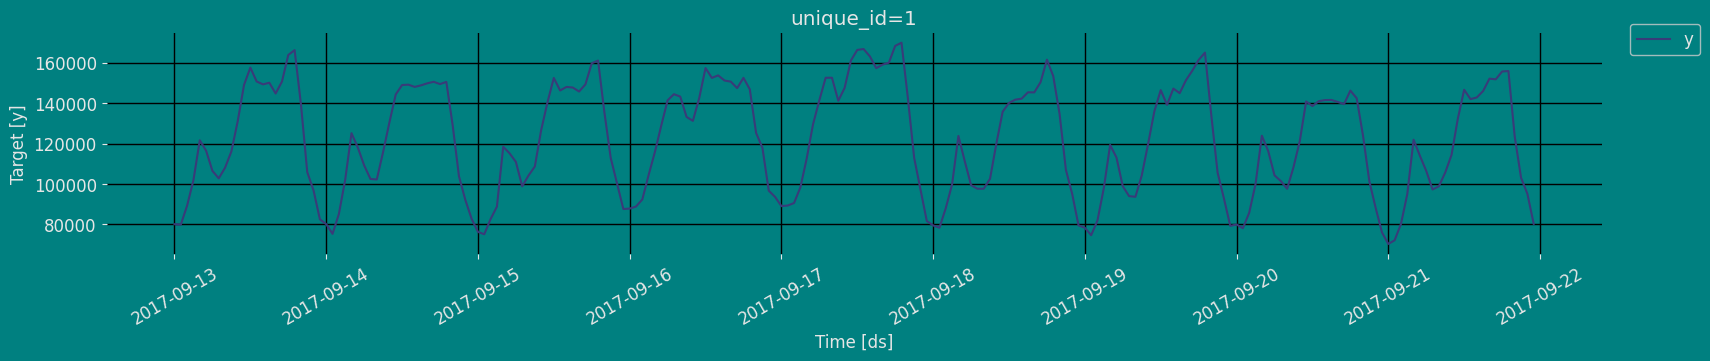

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(df)

### The Augmented Dickey-Fuller Test

An Augmented Dickey-Fuller (ADF) test is a type of statistical test that determines whether a unit root is present in time series data. Unit roots can cause unpredictable results in time series analysis. A null hypothesis is formed in the unit root test to determine how strongly time series data is affected by a trend. By accepting the null hypothesis, we accept the evidence that the time series data is not stationary. By rejecting the null hypothesis or accepting the alternative hypothesis, we accept the evidence that the time series data is generated by a stationary process. This process is also known as stationary trend. The values of the ADF test statistic are negative. Lower ADF values indicate a stronger rejection of the null hypothesis.

Augmented Dickey-Fuller Test is a common statistical test used to test whether a given time series is stationary or not. We can achieve this by defining the null and alternate hypothesis.

- Null Hypothesis: Time Series is non-stationary. It gives a time-dependent trend.
- Alternate Hypothesis: Time Series is stationary. In another term, the series doesn’t depend on time.

- ADF or t Statistic < critical values: Reject the null hypothesis, time series is stationary.
- ADF or t Statistic > critical values: Failed to reject the null hypothesis, time series is non-stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Dickey-Fuller test results for columns: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print("The data is not stationary")

In [ ]:
Augmented_Dickey_Fuller_Test_func(df["y"],'Ads')

Dickey-Fuller test results for columns: Ads
Test Statistic         -7.089634e+00
p-value                 4.444804e-10
No Lags Used            9.000000e+00
                            ...     
Critical Value (1%)    -3.462499e+00
Critical Value (5%)    -2.875675e+00
Critical Value (10%)   -2.574304e+00
Length: 7, dtype: float64
Conclusion:====>
Reject the null hypothesis
The data is stationary


### Autocorrelation plots

**Autocorrelation Function**

**Definition 1.** Let $\{x_t;1 ≤ t ≤ n\}$ be a time series sample of size n from $\{X_t\}$.
1. $\bar x = \sum_{t=1}^n \frac{x_t}{n}$ is called the sample mean of $\{X_t\}$.
2. $c_k =\sum_{t=1}^{n−k} (x_{t+k}- \bar x)(x_t−\bar x)/n$ is known as the sample autocovariance function of $\{X_t\}$.
3. $r_k = c_k /c_0$ is said to be the sample autocorrelation function of $\{X_t\}$. 

Note the following remarks about this definition:
 
* Like most literature, this guide uses ACF to denote the sample autocorrelation function as well as the autocorrelation function. What is denoted by ACF can easily be identified in context.

* Clearly c0 is the sample variance of $\{X_t\}$. Besides, $r_0 = c_0/c_0 = 1$ and for any integer $k, |r_k| ≤ 1$.

* When we compute the ACF of any sample series with a fixed length $n$, we cannot put too much confidence in the values of $r_k$ for large k’s, since fewer pairs of $(x_{t +k }, x_t )$ are available for calculating $r_k$ as $k$ is large. One rule of thumb is not to estimate $r_k$ for $k > n/3$, and another is $n ≥ 50, k ≤ n/4$. In any case, it is always a good idea to be careful.

* We also compute the ACF of a nonstationary time series sample by Definition 1. In this case, however, the ACF or $r_k$ very slowly or hardly tapers off as $k$ increases.

* Plotting the ACF $(r_k)$ against lag $k$ is easy but very helpful in analyzing time series sample. Such an ACF plot is known as a correlogram.

* If $\{X_t\}$ is stationary with $E(X_t)=0$ and $\rho_k =0$ for all $k \neq 0$,thatis,itisa white noise series, then the sampling distribution of $r_k$ is asymptotically normal with the mean 0 and the variance of $1/n$. Hence, there is about 95% chance that $r_k$ falls in the interval $[−1.96/\sqrt{n}, 1.96/\sqrt{n}]$.

Now we can give a summary that (1) if the time series plot of a time series clearly shows a trend or/and seasonality, it is surely nonstationary; (2) if the ACF $r_k$ very slowly or hardly tapers off as lag $k$ increases, the time series should also be nonstationary.

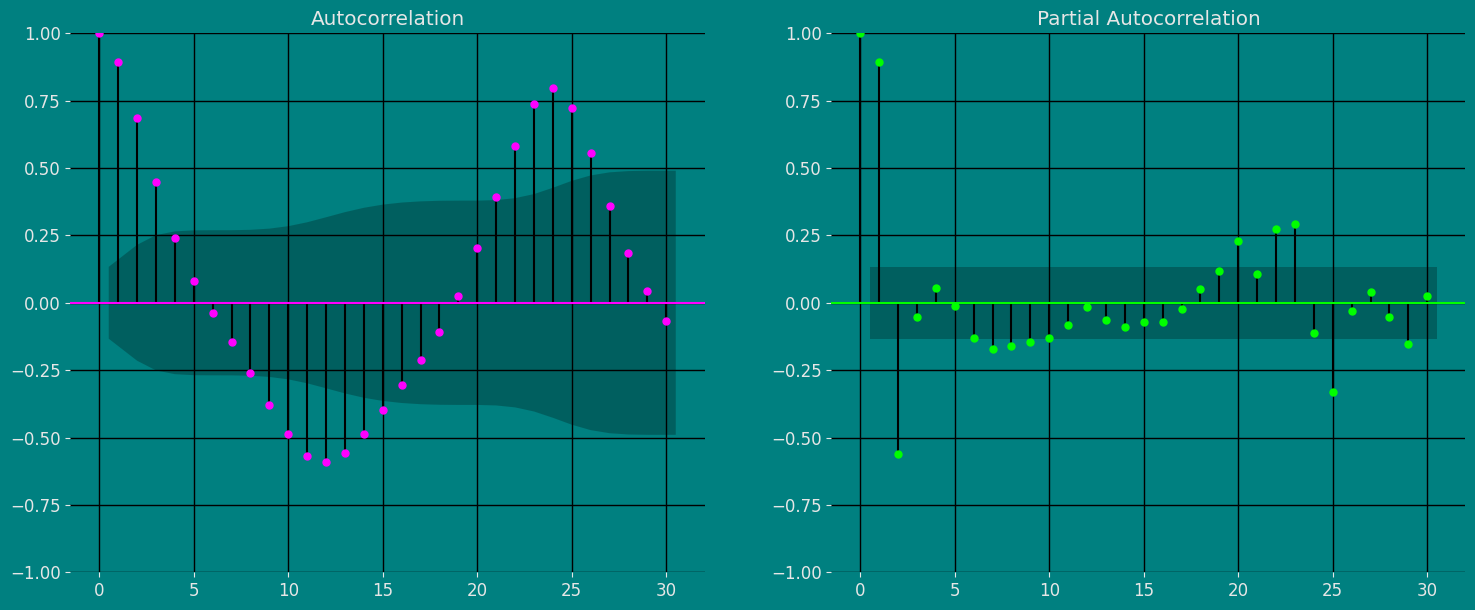

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df["y"],  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

### Decomposition of the time series

How to decompose a time series and why?

In time series analysis to forecast new values, it is very important to know past data. More formally, we can say that it is very important to know the patterns that values follow over time. There can be many reasons that cause our forecast values to fall in the wrong direction. Basically, a time series consists of four components. The variation of those components causes the change in the pattern of the time series. These components are:

* **Level:** This is the primary value that averages over time.
* **Trend:** The trend is the value that causes increasing or decreasing patterns in a time series.
* **Seasonality:** This is a cyclical event that occurs in a time series for a short time and causes short-term increasing or decreasing patterns in a time series.
* **Residual/Noise:** These are the random variations in the time series.

Combining these components over time leads to the formation of a time series. Most time series consist of level and noise/residual and trend or seasonality are optional values.

If seasonality and trend are part of the time series, then there will be effects on the forecast value. As the pattern of the forecasted time series may be different from the previous time series.

The combination of the components in time series can be of two types:
* Additive
* Multiplicative

### Additive time series

If the components of the time series are added to make the time series. Then the time series is called the additive time series. By visualization, we can say that the time series is additive if the increasing or decreasing pattern of the time series is similar throughout the series. The mathematical function of any additive time series can be represented by:
$$y(t) = level + Trend + seasonality + noise$$

### Multiplicative time series

If the components of the time series are multiplicative together, then the time series is called a multiplicative time series. For visualization, if the time series is having exponential growth or decline with time, then the time series can be considered as the multiplicative time series. The mathematical function of the multiplicative time series can be represented as.

$$y(t) = Level * Trend * seasonality * Noise$$

### Additive

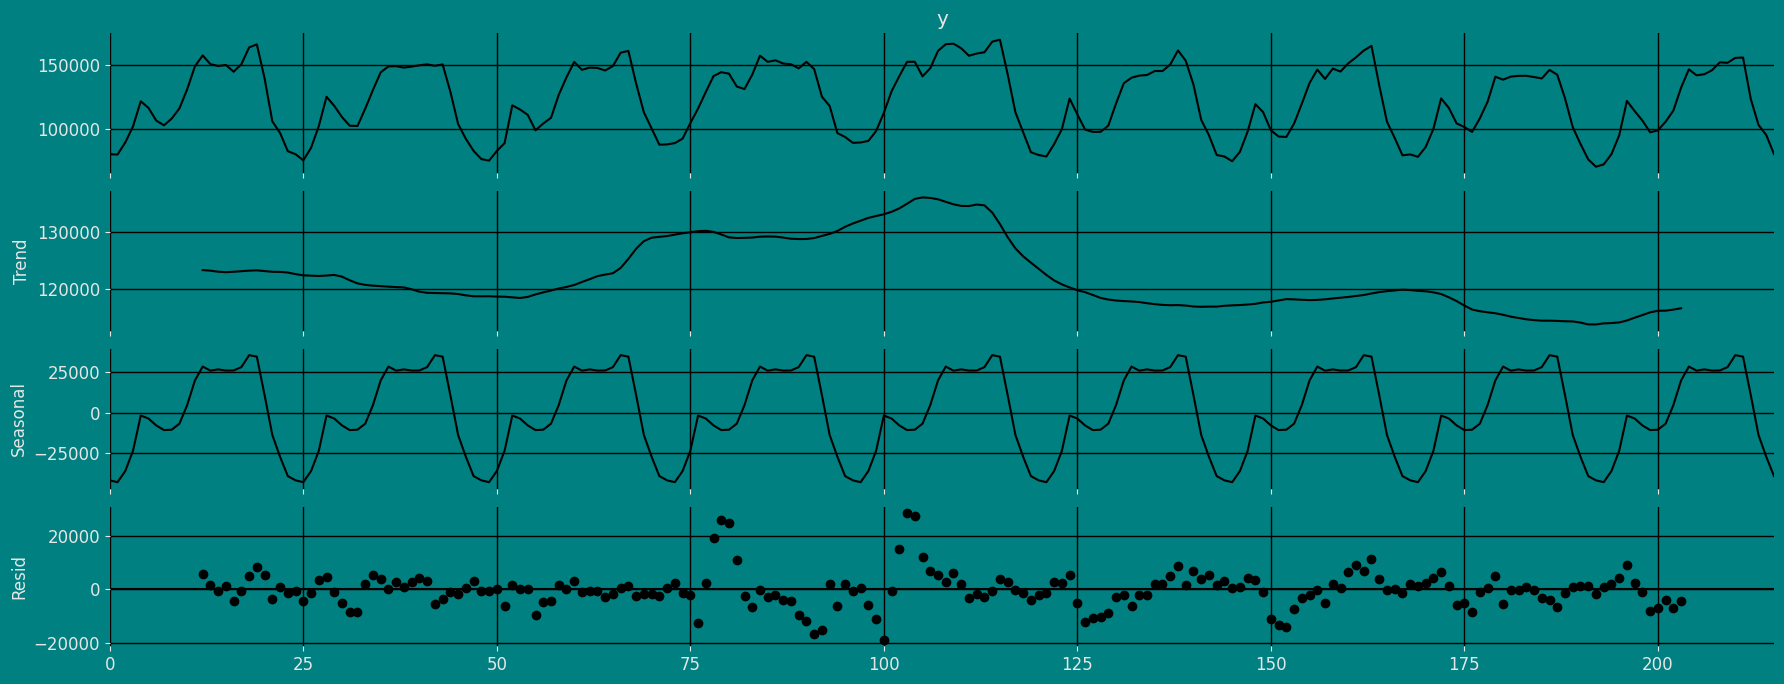

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
a = seasonal_decompose(df["y"], model = "additive", period=24)
a.plot();

### Multiplicative

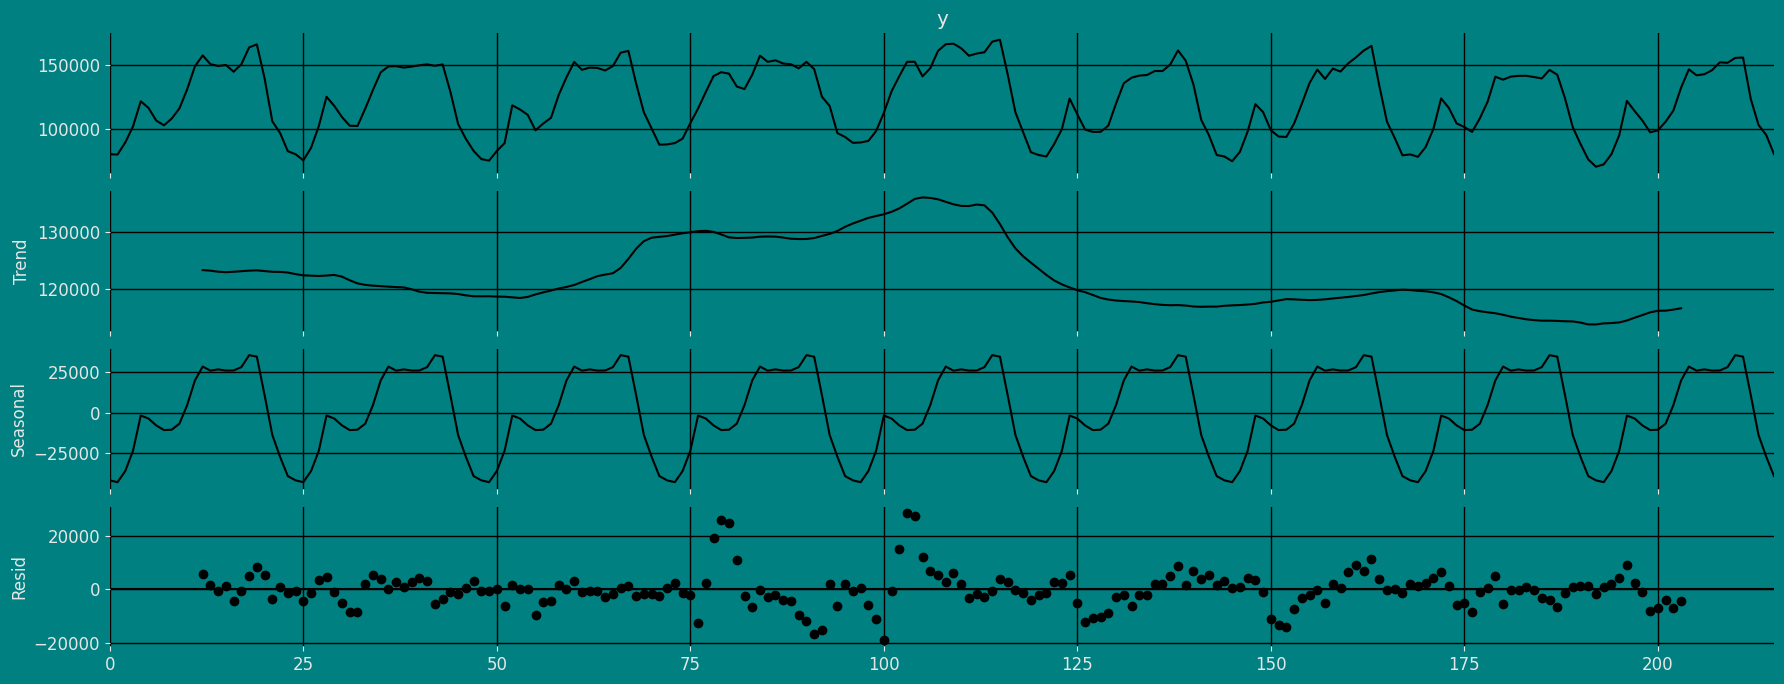

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
a = seasonal_decompose(df["y"], model = "Multiplicative", period=24)
a.plot();

## Split the data into training and testing<a class="anchor" id="splitting"></a>

Let's divide our data into sets

1. Data to train our `Holt Winters Model`.
2. Data to test our model

For the test data we will use the last 30 hours to test and evaluate the performance of our model.

In [ ]:
train = df[df.ds<='2017-09-20 17:00:00']
test = df[df.ds>'2017-09-20 17:00:00']

In [ ]:
train.shape, test.shape

((186, 3), (30, 3))

Now let's plot the training data and the test data.

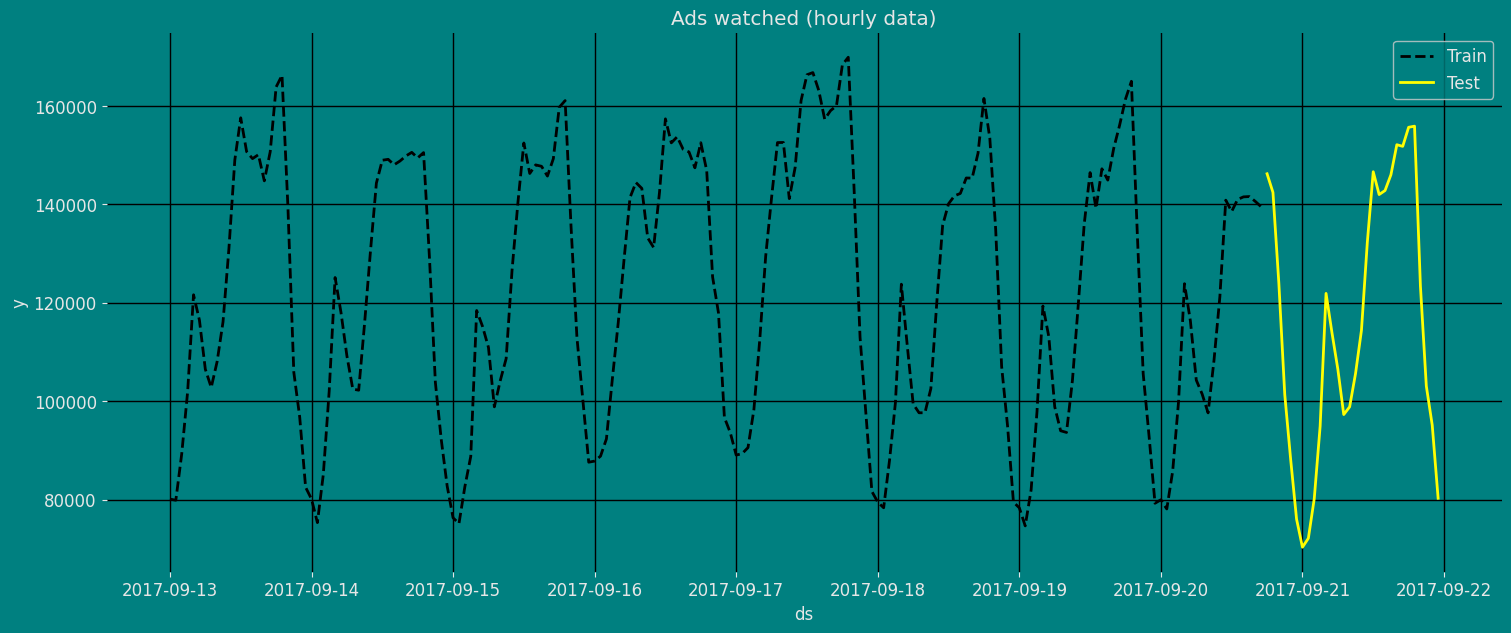

In [ ]:
sns.lineplot(train,x="ds", y="y", label="Train", linestyle="--",linewidth=2)
sns.lineplot(test, x="ds", y="y", label="Test", linewidth=2, color="yellow")
plt.title("Ads watched (hourly data)");
plt.show()

## Implementation of Holt-Winters Method with StatsForecast <a class="anchor" id="implementation"></a>

### Load libraries

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import HoltWinters

### Instantiating Model

Import and instantiate the models. Setting the argument is sometimes tricky. This article on [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/) by the master, Rob Hyndmann, can be useful for `season_length`.

In this case we are going to test two alternatives of the model, one additive and one multiplicative.

In [ ]:
season_length = 24 # Hourly data
horizon = len(test) # number of predictions

models = [HoltWinters(season_length=season_length, error_type="A", alias="Add"),
          HoltWinters(season_length=season_length, error_type="M", alias="Multi")]

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See [panda’s available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `n_jobs:` n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model:` a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
sf = StatsForecast(models=models, freq='h')

### Fit the Model

In [ ]:
sf.fit(df=train)

StatsForecast(models=[Add,Multi])

Let's see the results of our `Holt Winters Model`. We can observe it with the following instruction:

In [ ]:
result=sf.fitted_[0,0].model_
print(result.keys())
print(result['fit'])

dict_keys(['loglik', 'aic', 'bic', 'aicc', 'mse', 'amse', 'fit', 'residuals', 'components', 'm', 'nstate', 'fitted', 'states', 'par', 'sigma2', 'n_params', 'method', 'actual_residuals'])
results(x=array([ 2.60632491e-02,  1.53030002e-03,  3.22298668e-02,  9.00958233e-01,
        1.23628350e+05, -5.12405452e+01, -3.96677340e+04, -2.83800237e+04,
       -1.49514829e+04,  1.05413201e+04,  3.65409126e+04,  3.58433030e+04,
        2.93235036e+04,  2.66607410e+04,  2.55392078e+04,  2.60970444e+04,
        2.63155973e+04,  2.83192738e+04,  2.16640268e+04,  5.19120023e+03,
       -6.15595960e+03, -8.84863887e+03, -9.28320586e+03, -8.09549672e+03,
       -3.83755898e+03, -3.33456554e+03, -2.56333963e+04, -3.72181618e+04,
       -4.42497509e+04]), fn=4363.098387651742, nit=1001, simplex=None)


Let us now visualize the fitted values of our models.

As we can see, the result obtained above has an output in a dictionary, to extract each element from the dictionary we are going to use the `.get()` function to extract the element and then we are going to save it in a `pd.DataFrame()`.

In [ ]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

,residual Model
0,-1087.029091
1,623.989786
2,3054.101324
...,...
183,-2783.032921
184,-4618.147123
185,-8194.063498


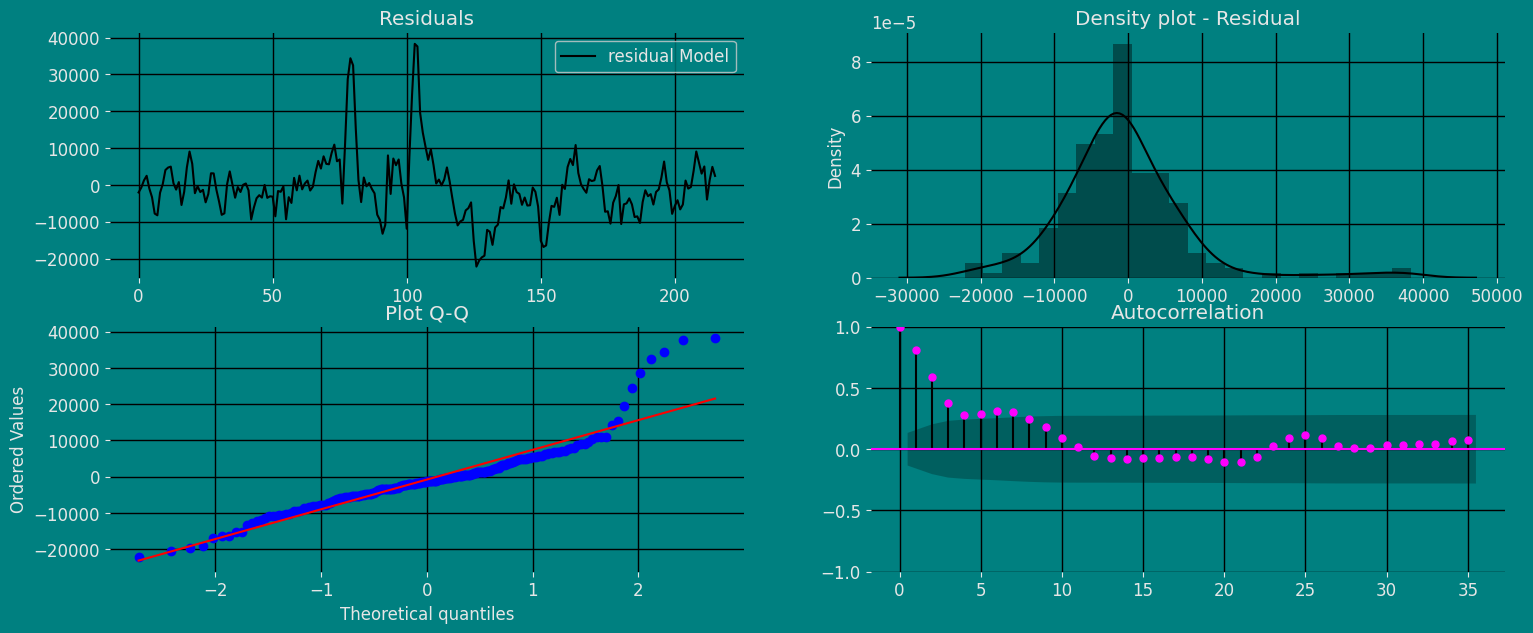

In [ ]:
import scipy.stats as stats

fig, axs = plt.subplots(nrows=2, ncols=2)

residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();

### Forecast Method

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 30 hours ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[90]` means that the model expects the real value to be inside that interval 90% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min. 

In [ ]:
Y_hat = sf.forecast(df=train, h=horizon, fitted=True)
Y_hat

,unique_id,ds,Add,Multi
0,1,2017-09-20 18:00:00,154164.609375,151414.984375
1,1,2017-09-20 19:00:00,154547.171875,152352.640625
2,1,2017-09-20 20:00:00,128790.359375,128274.789062
...,...,...,...,...
27,1,2017-09-21 21:00:00,103021.726562,103086.851562
28,1,2017-09-21 22:00:00,89544.054688,90028.406250
29,1,2017-09-21 23:00:00,78090.210938,78823.953125


With the forecast method we can also extract the fitted values from the model and visualize it graphically, with the following instruction we can do it.

In [ ]:
values=sf.forecast_fitted_values()
values.head()

,unique_id,ds,y,Add,Multi
0,1,2017-09-13 00:00:00,80115.0,81202.031250,79892.687500
1,1,2017-09-13 01:00:00,79885.0,79261.007812,78792.476562
2,1,2017-09-13 02:00:00,89325.0,86270.898438,85444.117188
3,1,2017-09-13 03:00:00,101930.0,97905.273438,97286.796875
4,1,2017-09-13 04:00:00,121630.0,120287.523438,118195.570312


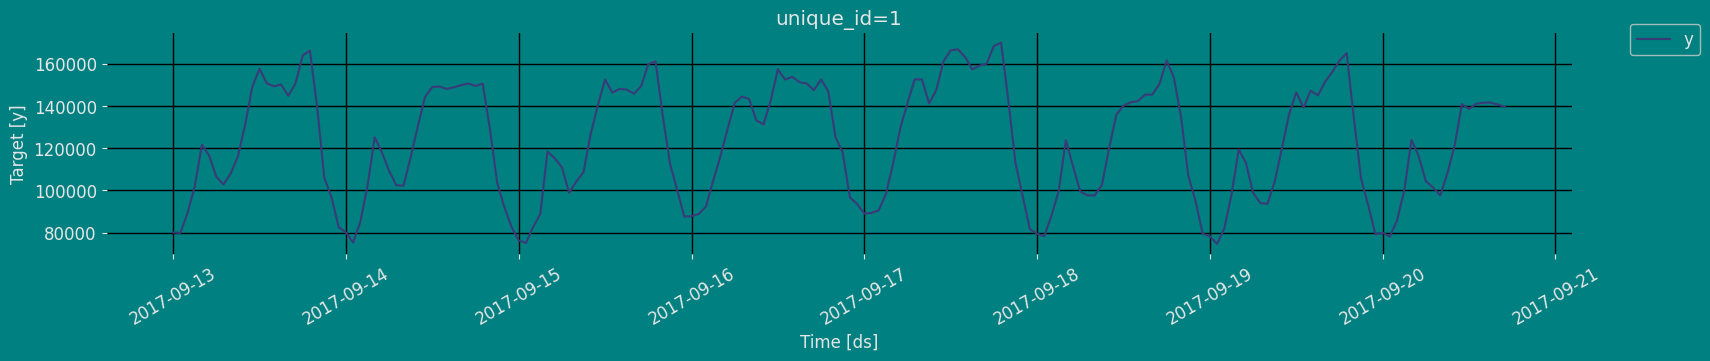

In [ ]:
StatsForecast.plot(values)

Adding 95% confidence interval with the forecast method

In [ ]:
sf.forecast(df=train, h=horizon, level=[95])

,unique_id,ds,Add,Add-lo-95,Add-hi-95,Multi,Multi-lo-95,Multi-hi-95
0,1,2017-09-20 18:00:00,154164.609375,134594.859375,173734.375000,151414.984375,125296.867188,177533.109375
1,1,2017-09-20 19:00:00,154547.171875,134970.062500,174124.265625,152352.640625,126234.515625,178470.765625
2,1,2017-09-20 20:00:00,128790.359375,109205.242188,148375.484375,128274.789062,102156.671875,154392.906250
...,...,...,...,...,...,...,...,...
27,1,2017-09-21 21:00:00,103021.726562,83118.632812,122924.812500,103086.851562,76659.867188,129513.835938
28,1,2017-09-21 22:00:00,89544.054688,69626.210938,109461.890625,90028.406250,63601.425781,116455.390625
29,1,2017-09-21 23:00:00,78090.210938,58157.574219,98022.843750,78823.953125,52396.972656,105250.937500


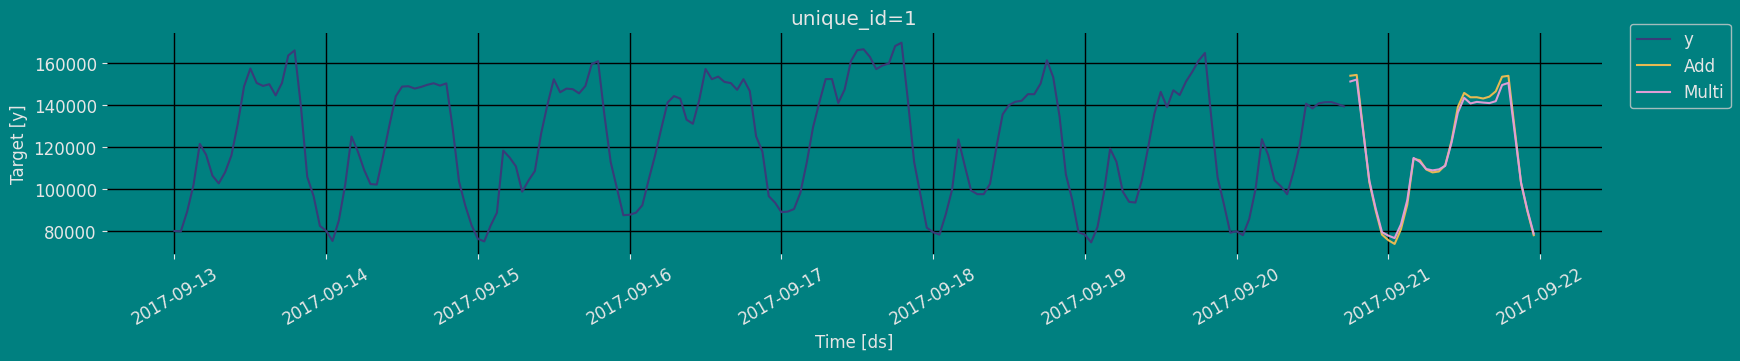

In [ ]:
sf.plot(train, Y_hat)

### Predict method with confidence interval

To generate forecasts use the predict method.

The predict method takes two arguments: forecasts the next `h` (for horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 30 hours ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[95]` means that the model expects the real value to be inside that interval 95% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

This step should take less than 1 second.

In [ ]:
sf.predict(h=horizon)

,unique_id,ds,Add,Multi
0,1,2017-09-20 18:00:00,154164.609375,151414.984375
1,1,2017-09-20 19:00:00,154547.171875,152352.640625
2,1,2017-09-20 20:00:00,128790.359375,128274.789062
...,...,...,...,...
27,1,2017-09-21 21:00:00,103021.726562,103086.851562
28,1,2017-09-21 22:00:00,89544.054688,90028.406250
29,1,2017-09-21 23:00:00,78090.210938,78823.953125


In [ ]:
forecast_df = sf.predict(h=horizon, level=[80,95])
forecast_df

,unique_id,ds,Add,Add-lo-95,Add-lo-80,Add-hi-80,Add-hi-95,Multi,Multi-lo-95,Multi-lo-80,Multi-hi-80,Multi-hi-95
0,1,2017-09-20 18:00:00,154164.609375,134594.859375,141368.640625,166960.593750,173734.375000,151414.984375,125296.867188,134337.265625,168492.703125,177533.109375
1,1,2017-09-20 19:00:00,154547.171875,134970.062500,141746.390625,167347.953125,174124.265625,152352.640625,126234.515625,135274.921875,169430.359375,178470.765625
2,1,2017-09-20 20:00:00,128790.359375,109205.242188,115984.335938,141596.375000,148375.484375,128274.789062,102156.671875,111197.070312,145352.515625,154392.906250
...,...,...,...,...,...,...,...,...,...,...,...,...
27,1,2017-09-21 21:00:00,103021.726562,83118.632812,90007.796875,116035.656250,122924.812500,103086.851562,76659.867188,85807.171875,120366.523438,129513.835938
28,1,2017-09-21 22:00:00,89544.054688,69626.210938,76520.476562,102567.632812,109461.890625,90028.406250,63601.425781,72748.734375,107308.085938,116455.390625
29,1,2017-09-21 23:00:00,78090.210938,58157.574219,65056.960938,91123.460938,98022.843750,78823.953125,52396.972656,61544.281250,96103.632812,105250.937500


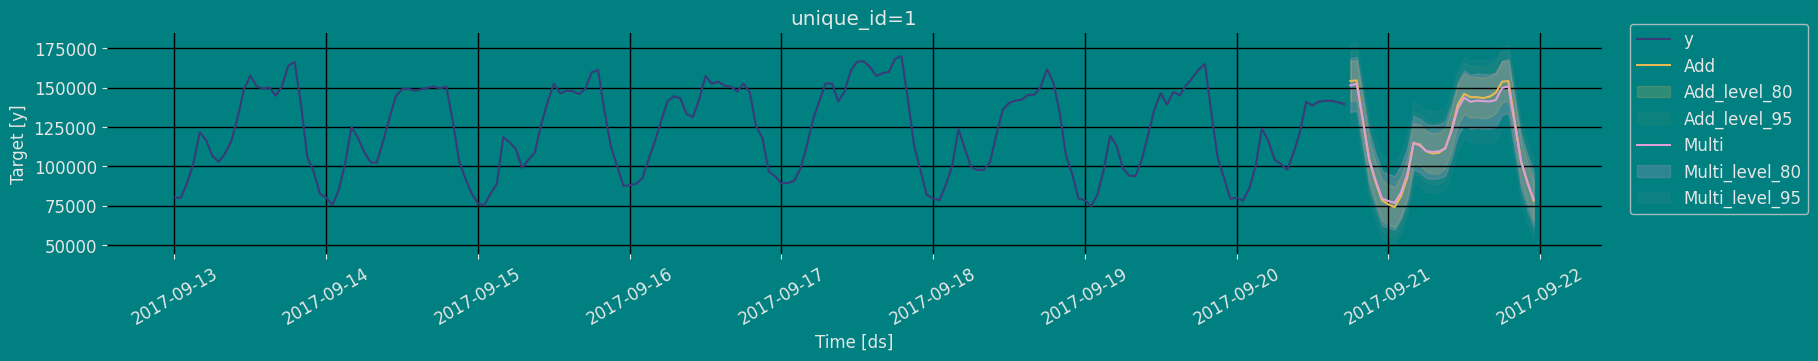

In [ ]:
sf.plot(train, forecast_df, level=[80, 95])

## Cross-validation <a class="anchor" id="cross_validate"></a>

In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

### Perform time series cross-validation


Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 5 months `(n_windows=)`, forecasting every second months `(step_size=12)`. Depending on your computer, this step should take around 1 min.

The cross_validation method from the StatsForecast class takes the following arguments.

* `df:` training data frame

* `h (int):` represents h steps into the future that are being forecasted. In this case, 12 months ahead.

* `step_size (int):` step size between each window. In other words: how often do you want to run the forecasting processes.

* `n_windows(int):` number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [ ]:
crossvalidation_df = sf.cross_validation(df=df,
                                         h=horizon,
                                         step_size=30,
                                         n_windows=3)

The crossvaldation_df object is a new data frame that includes the following columns:

* `unique_id:` series identifier.
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the `n_windows`.
* `y:` true value
* `model:` columns with the model’s name and fitted value.

In [ ]:
crossvalidation_df

,unique_id,ds,cutoff,y,Add,Multi
0,1,2017-09-18 06:00:00,2017-09-18 05:00:00,99440.0,134578.328125,133820.109375
1,1,2017-09-18 07:00:00,2017-09-18 05:00:00,97655.0,133548.781250,133734.000000
2,1,2017-09-18 08:00:00,2017-09-18 05:00:00,97655.0,134798.656250,135216.046875
...,...,...,...,...,...,...
87,1,2017-09-21 21:00:00,2017-09-20 17:00:00,103080.0,103021.726562,103086.851562
88,1,2017-09-21 22:00:00,2017-09-20 17:00:00,95155.0,89544.054688,90028.406250
89,1,2017-09-21 23:00:00,2017-09-20 17:00:00,80285.0,78090.210938,78823.953125


## Model Evaluation <a class="anchor" id="evaluate"></a>

Now we are going to evaluate our model with the results of the predictions, we will use different types of metrics MAE, MAPE, MASE, RMSE, SMAPE to evaluate the accuracy.

In [ ]:
from functools import partial

import utilsforecast.losses as ufl
from utilsforecast.evaluation import evaluate

In [ ]:
evaluate(
    test.merge(Y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=season_length), ufl.rmse, ufl.smape],
    train_df=train,
)

,unique_id,metric,Add,Multi
0,1,mae,4306.244531,4886.992188
1,1,mape,0.038087,0.043549
2,1,mase,0.532045,0.603797
3,1,rmse,5415.015573,5862.473702
4,1,smape,0.018708,0.021433


## References <a class="anchor" id="references"></a>

1. [Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python.](https://link.springer.com/book/10.1007/978-3-031-13584-2) 
2. Ivan Svetunkov. [Forecasting and Analytics with the Augmented Dynamic Adaptive Model (ADAM)](https://openforecast.org/adam/)
3. [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)
4. [Nixtla HoltWinters API](../../models#class-holtwinters)
5. [Pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
6. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting Principles and Practice (3rd ed)”](https://otexts.com/fpp3/tscv.html).
7. [Seasonal periods- Rob J Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).